### Data preparation - Summary Statistics for MSFT with daily / weekly / monthly / annual log returns

In [2]:
import pandas as pd 
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.diagnostic import lilliefors

# Download MSFT stock data for the specified period
MSFT = yf.download("MSFT", start="1986-12-31", end="2022-12-31")

# define the interval of dates
ss_start_date = pd.to_datetime('1986-12-31')
ss_end_date = pd.to_datetime('2022-12-31')

# extract the closing prices
Pt_d_all = MSFT["Adj Close"]
Pt_d_all = Pt_d_all.rename('Pt.d')

# mutate the Index into a DatetimeIndex
Pt_d_all.index = pd.to_datetime(Pt_d_all.index)  

#compute the log prices
pt_d_all = np.log(Pt_d_all)
pt_d_all = pt_d_all.rename('pt.d')

#compute weekly (w) monthly (m) and yearly (y) 
pt_w_all = pt_d_all.resample('W').last()
pt_m_all = pt_d_all.resample('M').last()
pt_y_all = pt_d_all.resample('Y').last()

# and rename them:
pt_w_all = pt_w_all.rename('pt.w.all')
pt_m_all = pt_m_all.rename('pt.m.all')
pt_y_all = pt_y_all.rename('pt.y.all')

rt_d_all_temp = pt_d_all.diff()

#compute log-returns for the entire history of MSFT
rt_d_all = pt_d_all.diff().dropna() #dropna remove the first NaN
rt_w_all = pt_w_all.diff().dropna()  
rt_m_all = pt_m_all.diff().dropna()     
rt_y_all = pt_y_all.diff().dropna()      

# and rename them: 
rt_d_all = rt_d_all.rename('rt_d_all')
rt_w_all = rt_w_all.rename('rt_w_all')
rt_m_all = rt_m_all.rename('rt_m_all')
rt_y_all = rt_y_all.rename('rt_y_all')

# Select the interval using loc (only for pandas series)
rt_d = rt_d_all.loc[ss_start_date:ss_end_date]
rt_w = rt_w_all.loc[ss_start_date:ss_end_date]
rt_m = rt_m_all.loc[ss_start_date:ss_end_date]
rt_y = rt_y_all.loc[ss_start_date:ss_end_date]


[*********************100%%**********************]  1 of 1 completed


Generates table exactly equal to the one in slide n.91
Personalized table of summary statistics. The following code creates a 'dictionary' with the data of MSFT sampled at different frequencies. We need a disctionary and not a matrix/dataframe, as the vectors have different lengths.

In [3]:
# X contains returns at different frequencies
X = {
    'daily': rt_d,
    'weekly': rt_w,
    'monthly': rt_m,
    'annual': rt_y
}

In [4]:
def multi_fun(x):
    stat_tab = {
        'Mean': round(np.mean(x) * 100,5),
        'St.Deviation': round(np.std(x) * 100,5),
        'Diameter.C.I.Mean': round(1.96 * np.sqrt(np.var(x) / len(x)) * 100,5),
        'Skewness': round(skew(x),5),
        'Kurtosis': round(kurtosis(x),5),
        'Excess.Kurtosis': round(kurtosis(x) - 3,5),
        'Min': round(np.min(x) * 100,5),
        'Quant5': round(np.quantile(x, 0.05) * 100,5),
        'Quant25': round(np.quantile(x, 0.25) * 100,5),
        'Median': round(np.quantile(x, 0.50) * 100,5),
        'Quant75': round(np.quantile(x, 0.75) * 100,5),
        'Quant95': round(np.quantile(x, 0.95) * 100,5),
        'Max': round(np.max(x) * 100,5),
        'Jarque.Bera.stat': round(jarque_bera(x)[0],5),
        'Jarque.Bera.pvalue.X100': round(jarque_bera(x)[1] *100,5),
        'Lillie.test.stat': round(lilliefors(x)[0],5),
        'Lillie.test.pvalue.X100': round(lilliefors(x)[1] * 100,5),
        'N.obs': len(x)
    }
    return stat_tab 
    

Defines a new dictionary to store the stats:

a. key will contains the key (i.e., daily, weekly, ...)

b. data will contains the returns

Apply multi_fun to each data series

Define a DataFrame with the stats results

Print the dictionary

In [5]:

# 1. 
statistics_dict = {}

# 2.
statistics_dict = {
    key: multi_fun(data.iloc[1:]) 
    for key, data in X.items()
}
# apply multi_fun to each returns ("series" in pandas) 
# which is located in one of the four key of our dictionary X   
# 3.
statistics_df = pd.DataFrame(statistics_dict)

# 4.
print(statistics_df)

                               daily      weekly    monthly    annual
Mean                         0.08539     0.40230    1.69836  19.78676
St.Deviation                 2.13306     4.30162    8.88126  35.78845
Diameter.C.I.Mean            0.04389     0.19466    0.83848  11.85673
Skewness                    -0.61745    -0.24075   -0.15771  -1.11453
Kurtosis                    15.23597     3.26921    1.96523   1.92708
Excess.Kurtosis             12.23597     0.26921   -1.03477  -1.07292
Min                        -35.83319   -29.41399  -42.08770 -99.01516
Quant5                      -3.07831    -6.49094  -13.17151 -40.62121
Quant25                     -0.92583    -1.81673   -3.70479   2.34715
Median                       0.03624     0.36800    2.09149  20.45058
Quant75                      1.12076     2.70779    6.48750  43.54941
Quant95                      3.36071     7.54393   15.19122  67.21636
Max                         17.86919    20.51400   34.20145  79.64286
Jarque.Bera.stat    

### Figure 14 - MSFT  Daily Log-Return and Daily Squared Log-Return

[*********************100%%**********************]  1 of 1 completed


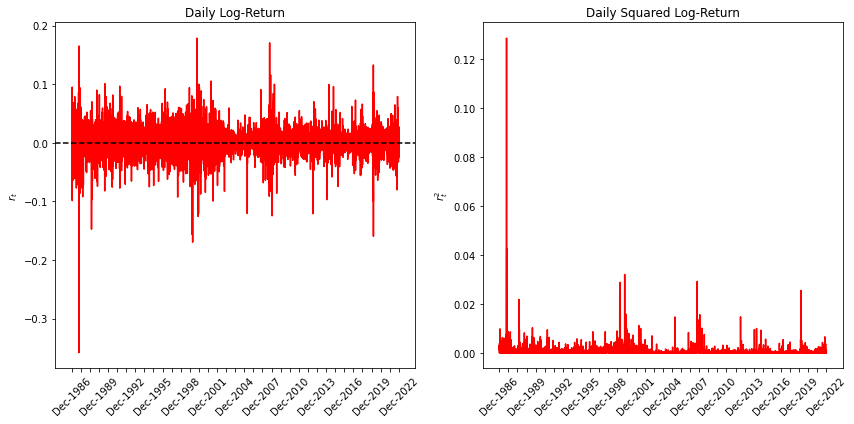

In [18]:
from scipy.stats import gaussian_kde, norm, iqr, skew, kurtosis, jarque_bera, kstest, anderson
import scipy.stats as stats
import yfinance as yf
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 

# Get MSFT data
MSFT = yf.download("MSFT", start="1986-12-31", end="2022-12-31")

# Compute daily log-returns 
log_returns_daily = np.log(MSFT['Adj Close']).diff().dropna()

# Compute their squares
log_returns_squared = log_returns_daily ** 2

# Define the plots layout
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# 1st plot: time series of daily log-returns
axs[0].plot(log_returns_daily.index, log_returns_daily, color='red')
axs[0].axhline(y=0, color='black', linestyle='--')
axs[0].set_ylabel('$r_t$')
axs[0].set_title('Daily Log-Return')

# Add "Dec-Year" at the end of each year (first plot)
date_labels = pd.date_range(start="1986-12-31", end="2022-12-31", freq='A-DEC')
formatted_labels = [f'Dec-{date.year}' if date.year % 3 == 0 else '' for date in date_labels]
axs[0].set_xticks(date_labels)
axs[0].set_xticklabels(formatted_labels, rotation=45)

# 2nd plot: time series of daily log-returns
axs[1].plot(log_returns_squared.index, log_returns_squared, color='red')
axs[1].set_ylabel('$r_t^2$')
axs[1].set_title('Daily Squared Log-Return')

axs[1].set_xticks(date_labels)
axs[1].set_xticklabels(formatted_labels, rotation=45)

# Remove x-labels
axs[0].set_xlabel('')
axs[1].set_xlabel('')

# Set the layout
plt.tight_layout()

# Save the figure in png format
plt.savefig('MSFT_rt_SQUAREDrt_d_1986_2022.png', format='png', bbox_inches='tight')

plt.show()

### Max volatility date and value

In [19]:
max_volatility_date = log_returns_squared.idxmax()


max_volatility_value = log_returns_squared.max()

print(f"The highest volotility was {max_volatility_date} with the value of {max_volatility_value}")

The highest volotility was 1987-10-19 00:00:00 with the value of 0.12840192126121777


### Figure 15 - Rolling 1-Year Volatility of MSFT Stock

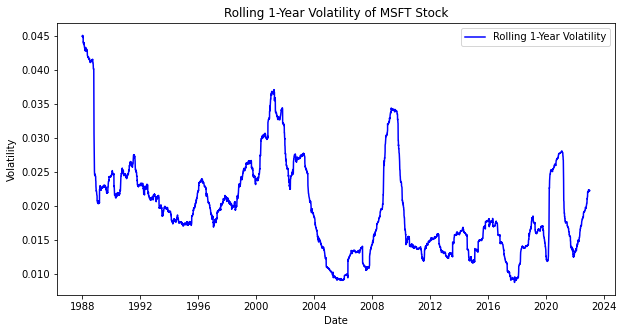

In [20]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

rolling_volatility = log_returns_daily.rolling(window=252).std()

plt.figure(figsize=(10, 5))
plt.plot(rolling_volatility.index, rolling_volatility, label='Rolling 1-Year Volatility', color='blue')
plt.title('Rolling 1-Year Volatility of MSFT Stock')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

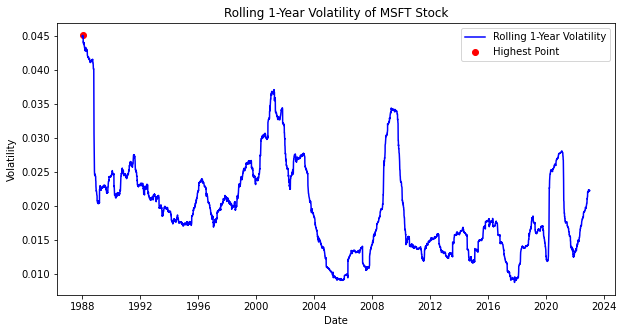

Highest Volatility: 0.04502212953275088 on 1988-01-08 00:00:00


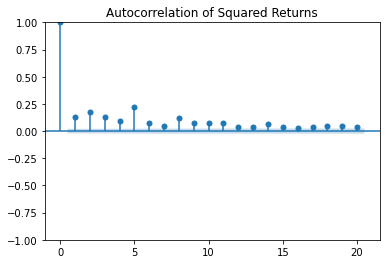

In [30]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already defined log_returns_daily

rolling_volatility = log_returns_daily.rolling(window=252).std()

# Find the index of the maximum volatility
max_volatility_index = np.argmax(rolling_volatility)

# Get the corresponding date and volatility value
max_volatility_date = rolling_volatility.index[max_volatility_index]
max_volatility_value = rolling_volatility.iloc[max_volatility_index]

# Plot the graph
plt.figure(figsize=(10, 5))
plt.plot(rolling_volatility.index, rolling_volatility, label='Rolling 1-Year Volatility', color='blue')
plt.scatter(max_volatility_date, max_volatility_value, color='red', label='Highest Point')
plt.title('Rolling 1-Year Volatility of MSFT Stock')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

print(f'Highest Volatility: {max_volatility_value} on {max_volatility_date}')

from statsmodels.graphics.tsaplots import plot_acf

# Compute squared returns
squared_returns = log_returns_daily**2

# Compute ACF of squared returns
plot_acf(squared_returns, lags=20)
plt.title('Autocorrelation of Squared Returns')
plt.show()

### Figure 16 - MSFT autocorrelation of log returns

[*********************100%%**********************]  1 of 1 completed


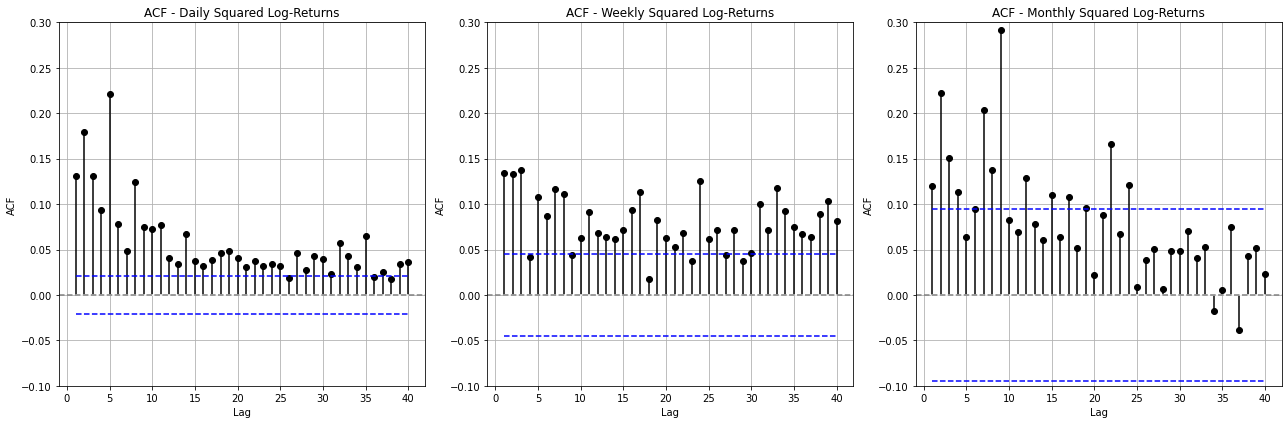

In [21]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf

# Download MSFT data over the specified period.
MSFT = yf.download("MSFT", start="1986-12-31", end="2022-12-31")

# Extract daily log-returns.
log_returns_daily = np.log(MSFT['Adj Close']).diff().dropna()
# Get weekly log-returns
log_returns_weekly = np.log(MSFT['Adj Close']).resample('W').last().diff().dropna()
# Get monthly log-returns
log_returns_monthly = np.log(MSFT['Adj Close']).resample('M').last().diff().dropna()


# Calculate empirical autocorrelation.
lags = 40
acf_values_daily = acf(log_returns_daily**2, nlags=lags)

# Calculates confidence bands at 1.96 times the standard deviation of the autocorrelation.
confint = 1.96 / np.sqrt(len(log_returns_daily))
confint_upper = np.full(lags, confint)
confint_lower = -np.full(lags, confint)

# Creating the three side-by-side graphs.
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# ACF of daily log-returns with confidence bands.
axs[0].stem(np.arange(1, lags + 1), acf_values_daily[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
axs[0].axhline(y=0, color='gray', linestyle='--')
axs[0].plot(np.arange(1, lags + 1), confint_upper, color='blue', linestyle='dashed')
axs[0].plot(np.arange(1, lags + 1), confint_lower, color='blue', linestyle='dashed')
axs[0].set_ylim(-0.1, 0.3)
axs[0].set_title('ACF - Daily Squared Log-Returns')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF')
axs[0].grid(True)

# ACF of weekly log-returns with confidence bands.
acf_values_weekly = acf(log_returns_weekly**2, nlags=lags)
confint_weekly = 1.96 / np.sqrt(len(log_returns_weekly))
confint_weekly_upper = np.full(lags, confint_weekly)
confint_weekly_lower = -np.full(lags, confint_weekly)

axs[1].stem(np.arange(1, lags + 1), acf_values_weekly[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
axs[1].axhline(y=0, color='gray', linestyle='--')
axs[1].plot(np.arange(1, lags + 1), confint_weekly_upper, color='blue', linestyle='dashed')
axs[1].plot(np.arange(1, lags + 1), confint_weekly_lower, color='blue', linestyle='dashed')
axs[1].set_ylim(-0.1, 0.3)
axs[1].set_title('ACF - Weekly Squared Log-Returns')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('ACF')
axs[1].grid(True)

# ACF of monthly log-returns with confidence bands.
acf_values_monthly = acf(log_returns_monthly**2, nlags=lags)
confint_monthly = 1.96 / np.sqrt(len(log_returns_monthly))
confint_monthly_upper = np.full(lags, confint_monthly)
confint_monthly_lower = -np.full(lags, confint_monthly)

axs[2].stem(np.arange(1, lags + 1), acf_values_monthly[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
axs[2].axhline(y=0, color='gray', linestyle='--')
axs[2].plot(np.arange(1, lags + 1), confint_monthly_upper, color='blue', linestyle='dashed')
axs[2].plot(np.arange(1, lags + 1), confint_monthly_lower, color='blue', linestyle='dashed')
axs[2].set_ylim(-0.1, 0.3)
axs[2].set_title('ACF - Monthly Squared Log-Returns')
axs[2].set_xlabel('Lag')
axs[2].set_ylabel('ACF')
axs[2].grid(True)

# Adjusting the spacing between graphs.
plt.tight_layout()

# Save the graph in png format.
plt.savefig('MSFT_rt_SQUAREDrt_d_1986_2022.png', format='png', bbox_inches='tight')

plt.show()

### Figure 17 - MSFT autocorrelation of absolute returns

[*********************100%%**********************]  1 of 1 completed


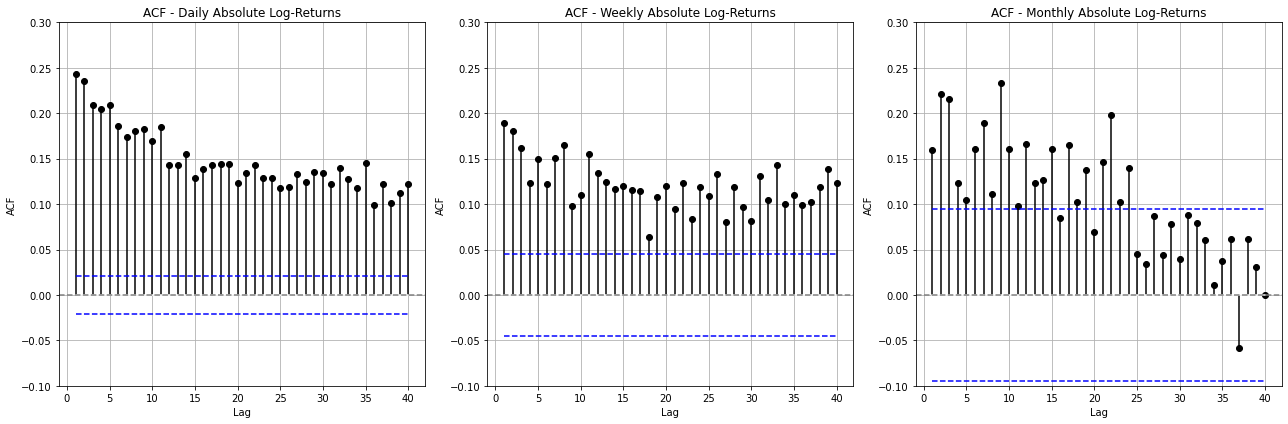

In [22]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf

# Get MSFT data
MSFT = yf.download("MSFT", start="1986-12-31", end="2022-12-31")

# Compute the daily log-returns
log_returns_daily = np.log(MSFT['Adj Close']).diff().dropna()

# Compute the empirical acf on absolute returns
lags = 40
acf_values_daily = acf(abs(log_returns_daily), nlags=lags)

# Bartlett Intervals
confint = 1.96 / np.sqrt(len(log_returns_daily))
confint_upper = np.full(lags, confint)
confint_lower = -np.full(lags, confint)

# Set the figure layout
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Daily log-returns ACF
axs[0].stem(np.arange(1, lags + 1), acf_values_daily[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
axs[0].axhline(y=0, color='gray', linestyle='--')
axs[0].plot(np.arange(1, lags + 1), confint_upper, color='blue', linestyle='dashed')
axs[0].plot(np.arange(1, lags + 1), confint_lower, color='blue', linestyle='dashed')
axs[0].set_ylim(-0.1, 0.3)
axs[0].set_title('ACF - Daily Absolute Log-Returns')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF')
axs[0].grid(True)

# Weekly log-returns ACF
acf_values_weekly = acf(abs(log_returns_weekly), nlags=lags)
confint_weekly = 1.96 / np.sqrt(len(log_returns_weekly))
confint_weekly_upper = np.full(lags, confint_weekly)
confint_weekly_lower = -np.full(lags, confint_weekly)

axs[1].stem(np.arange(1, lags + 1), acf_values_weekly[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
axs[1].axhline(y=0, color='gray', linestyle='--')
axs[1].plot(np.arange(1, lags + 1), confint_weekly_upper, color='blue', linestyle='dashed')
axs[1].plot(np.arange(1, lags + 1), confint_weekly_lower, color='blue', linestyle='dashed')
axs[1].set_ylim(-0.1, 0.3)
axs[1].set_title('ACF - Weekly Absolute Log-Returns')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('ACF')
axs[1].grid(True)

# Monthly log-returns ACF
acf_values_monthly = acf(abs(log_returns_monthly), nlags=lags)
confint_monthly = 1.96 / np.sqrt(len(log_returns_monthly))
confint_monthly_upper = np.full(lags, confint_monthly)
confint_monthly_lower = -np.full(lags, confint_monthly)

axs[2].stem(np.arange(1, lags + 1), acf_values_monthly[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
axs[2].axhline(y=0, color='gray', linestyle='--')
axs[2].plot(np.arange(1, lags + 1), confint_monthly_upper, color='blue', linestyle='dashed')
axs[2].plot(np.arange(1, lags + 1), confint_monthly_lower, color='blue', linestyle='dashed')
axs[2].set_ylim(-0.1, 0.3)
axs[2].set_title('ACF - Monthly Absolute Log-Returns')
axs[2].set_xlabel('Lag')
axs[2].set_ylabel('ACF')
axs[2].grid(True)

# Improve the layout
plt.tight_layout()

# Save the figure in png format
plt.savefig('MSFT_ACF_ABSrt_dwm_1986_2022.png', format='png', bbox_inches='tight')

plt.show()


### Max Volatility Day

In [23]:
max_volatility_day_daily = log_returns_daily.abs().idxmax()
max_volatility_value_daily = log_returns_daily.abs().max()

max_volatility_day_weekly = log_returns_weekly.abs().idxmax()
max_volatility_value_weekly = log_returns_weekly.abs().max()

max_volatility_day_monthly = log_returns_monthly.abs().idxmax()
max_volatility_value_monthly = log_returns_monthly.abs().max()

max_volatility_day_daily_squared = (log_returns_daily**2).idxmax()
max_volatility_value_daily_squared = (log_returns_daily**2).max()

max_volatility_day_weekly_squared = (log_returns_weekly**2).idxmax()
max_volatility_value_weekly_squared = (log_returns_weekly**2).max()

max_volatility_day_monthly_squared = (log_returns_monthly**2).idxmax()
max_volatility_value_monthly_squared = (log_returns_monthly**2).max()

print(f"Max Volatility Day (Daily Log-Returns): {max_volatility_day_daily}, Value: {max_volatility_value_daily}")
print(f"Max Volatility Day (Weekly Log-Returns): {max_volatility_day_weekly}, Value: {max_volatility_value_weekly}")
print(f"Max Volatility Day (Monthly Log-Returns): {max_volatility_day_monthly}, Value: {max_volatility_value_monthly}")
print(f"Max Volatility Day (Daily Squared Log-Returns): {max_volatility_day_daily_squared}, Value: {max_volatility_value_daily_squared}")
print(f"Max Volatility Day (Weekly Squared Log-Returns): {max_volatility_day_weekly_squared}, Value: {max_volatility_value_weekly_squared}")
print(f"Max Volatility Day (Monthly Squared Log-Returns): {max_volatility_day_monthly_squared}, Value: {max_volatility_value_monthly_squared}")

Max Volatility Day (Daily Log-Returns): 1987-10-19 00:00:00, Value: 0.3583324441472595
Max Volatility Day (Weekly Log-Returns): 1987-10-25 00:00:00, Value: 0.2941391077659876
Max Volatility Day (Monthly Log-Returns): 2000-04-30 00:00:00, Value: 0.4208776403361285
Max Volatility Day (Daily Squared Log-Returns): 1987-10-19 00:00:00, Value: 0.12840214052854887
Max Volatility Day (Weekly Squared Log-Returns): 1987-10-25 00:00:00, Value: 0.08651781471737127
Max Volatility Day (Monthly Squared Log-Returns): 2000-04-30 00:00:00, Value: 0.17713798813490755


### Figure 18 - Cross-Correlation between daily and the square of its daily return for various delays (lags)

[*********************100%%**********************]  1 of 1 completed


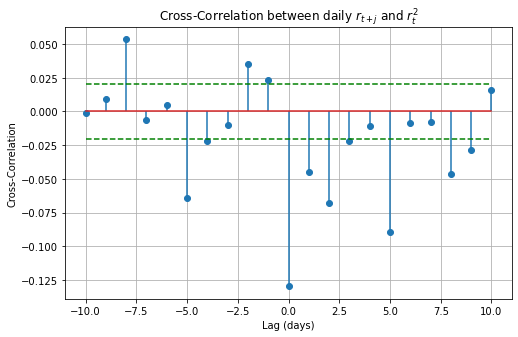

In [24]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf
import scipy.signal as ss

# define a function
def ccf(x, y, lag_max = 100):
    # compute correlation
    result = ss.correlate(y - np.mean(y), x - np.mean(x), method='direct') / (np.std(y) * np.std(x) * len(y))
    # define the length
    length = (len(result) - 1) // 2
    lo = length - lag_max
    hi = length + (lag_max + 1)

    return result[lo:hi]

# Get MSFT data
MSFT = yf.download("MSFT", start="1986-12-31", end="2022-12-31")

# Compute the daily log-returns
log_returns_daily = np.log(MSFT['Adj Close']).diff().dropna()

# choose the max lag and execute the function
lag_max = 10
cross_corr = ccf(log_returns_daily,log_returns_daily**2,lag_max=lag_max)

# plot results
lags = np.arange(-lag_max, lag_max + 1)

# ACF dei log-returns mensili con bande di confidenza
confint_daily = 1.96 / np.sqrt(len(log_returns_daily))
confint_daily_upper = np.full(len(lags), confint_daily)
confint_daily_lower = -np.full(len(lags), confint_daily)

plt.figure(figsize=(8, 5))
plt.stem(lags, cross_corr)
plt.plot(lags, confint_daily_upper, color='green', linestyle='dashed')
plt.plot(lags, confint_daily_lower, color='green', linestyle='dashed')
plt.xlabel('Lag (days)')
plt.ylabel('Cross-Correlation')
plt.title('Cross-Correlation between daily $r_{t+j}$ and $r_t^2$')
plt.grid(True)

# add the bartlet intervals

plt.savefig('MSFT_corr_rtmj_rt2_1986_2022.png', format='png', bbox_inches='tight')

plt.show()

### Figure 19 - Graph: VXN vs. MSFT leverage effect (we take data from 1990-01-01 onwards as VIX is only available from then)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


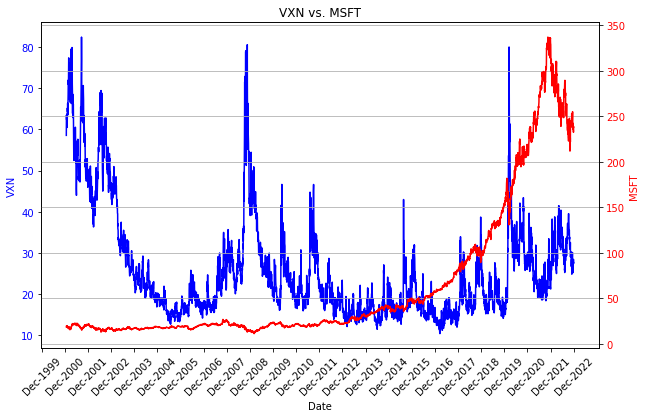

In [25]:
# get VXN and MSFT data
VXN = yf.download("^VXN", start="1990-01-01", end="2022-12-31") #we take 1990-01-01 as Vix is only available from then
MSFT = yf.download("MSFT", start="1990-01-01", end="2022-12-31")

# extract the adjusted closing prices
Pt_d = VXN["Adj Close"]
MSFT_d = MSFT["Adj Close"]

# rename the columns
Pt_d = Pt_d.rename('Pt.d')
MSFT_d = MSFT_d.rename('MSFT.d')
# mutate the Index into a DatetimeIndex
MSFT_d.index = pd.to_datetime(MSFT_d.index)  

# merge the two datasets and rename columns
merged_df = pd.merge(Pt_d, MSFT_d, on='Date', how='outer') # outer: only commond indexes (dates)
merged_df.head()

# Compute changes in pt and MSFT compared to previous period (NaN are kept)
diff_df = merged_df.diff()
diff_df.head()

# remove from the price dataframe
merged_df = merged_df.dropna()
# and from the second one
diff_df = diff_df.dropna()

# define the figure parameters
fig, ax1 = plt.subplots(figsize=(10, 6))

# Customizing x-axis labels for December of each year
date_labels = pd.date_range(start='1990-01-01', end='2022-12-31', freq='A-DEC')
formatted_labels = [f'Dec-{date.year}' for date in date_labels]
# Add label and rotate them
plt.xticks(date_labels, formatted_labels, rotation=45)

# work on the first y-axis: VXN
ax1.plot(merged_df.index, merged_df['Pt.d'], label='MSFT Prices', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('VXN', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# work on the second y-axis: MSFT
ax2 = ax1.twinx()
ax2.plot(merged_df.index, merged_df['MSFT.d'], label='MSFT', color='red')
ax2.set_ylabel('MSFT', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Aggiungi etichette al grafico
plt.title('VXN vs. MSFT')
plt.grid(True)


plt.savefig('VXN_MSFT_1990_2022.png', format='png', bbox_inches='tight')

# Mostra il grafico
plt.show()

### Figure 20 - VXN vs MSFT (diff) Scatterplot

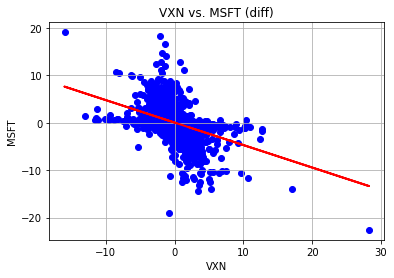

In [26]:
plt.scatter(diff_df['Pt.d'], diff_df['MSFT.d'], color='blue', marker='o')

#add labels and title
plt.xlabel('VXN')
plt.ylabel('MSFT')
plt.title('VXN vs. MSFT (diff)')
plt.grid(True)
# add regression line
coefficients = np.polyfit(diff_df['Pt.d'], diff_df['MSFT.d'], 1)
regression_line = np.polyval(coefficients, diff_df['Pt.d'])

plt.plot(diff_df['Pt.d'], regression_line, color='red', linewidth=2)

plt.savefig('VXN_corr_rt_dMSFT_1990_2022.png', format='png', bbox_inches='tight')

# show plot
plt.show()

### Correlation and Covariance for MSFT & VXN

In [27]:
import pandas as pd

data = {'VXN': diff_df['Pt.d'], 'MSFT': diff_df['MSFT.d']}
df = pd.DataFrame(data)

correlation = df.corr().loc['VXN', 'MSFT']
print(f'Correlation: {correlation}')

covariance = df.cov().loc['VXN', 'MSFT']
print(f'Covariation: {covariance}')

Correlation: -0.4505947869091503
Covariation: -1.490436254852354
